In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import glob

def filtering_func_4(freqs, ffts, avg_phases, f1, f2):  #passing 2D complex matrix as ffts
    noise_ffts = ffts.copy()

    #average the rows
    avg_fft = np.mean(np.abs(ffts), axis = 0)
    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = avg_fft[valid_indices]

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(fft_in_range == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]

    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = avg_phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    mask = np.ones(noise_ffts.shape, dtype=bool)
    mask[:, general_peak_indices] = False
    noise_ffts[mask] = complex(0, 0)
    return noise_ffts, peak_f, peak_phase

In [2]:
hour = '15.42'
day = '08082024'

In [3]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        print(df)
        if i == 0:
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)       

              Time    Channel D
0             (us)         (mV)
1       0.00000000  -1.96850400
2       0.00080000  -1.57480300
3       0.00160000  -1.18110200
4       0.00240000  -0.78740150
...            ...          ...
62500  49.99920067   0.00000000
62501  50.00000067   0.39370070
62502  50.00080067  -0.39370070
62503  50.00160067  -1.18110200
62504  50.00240067  -1.18110200

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000   1.57480300
2       0.00080000   0.78740150
3       0.00160000   0.00000000
4       0.00240000   0.00000000
...            ...          ...
62500  49.99920067   1.57480300
62501  50.00000067   0.78740150
62502  50.00080067  -0.39370070
62503  50.00160067  -2.75590500
62504  50.00240067  -4.72440900

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000  -0.39370070
2       0.00080000  -0.39370070
3       0.00160000   0.39370070
4       0.00240000  

In [4]:
N = len(times)
print(f"len(times): {N}")

len(times): 62504


## FFT

In [5]:
span = times[-1]
print(f"span: {span}") 
step = span / N
f_s = 1 / step
print(f"f_s = {f_s}")

freqs = fft.fftfreq(N, 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') #this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905824
last freq: -0.019999039778103522
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [28]:
all_magnitudes = fft.fft(all_amplitudes, axis = 1)
all_phases = np.angle(all_magnitudes)

avg_wf = np.mean(all_amplitudes, axis = 0) 
reconstructed_fft = fft.fft(avg_wf)

n = np.max(reconstructed_fft)

avg_phases = np.angle(reconstructed_fft)
avg_phases_2 = np.mean(all_phases, axis = 0)

c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


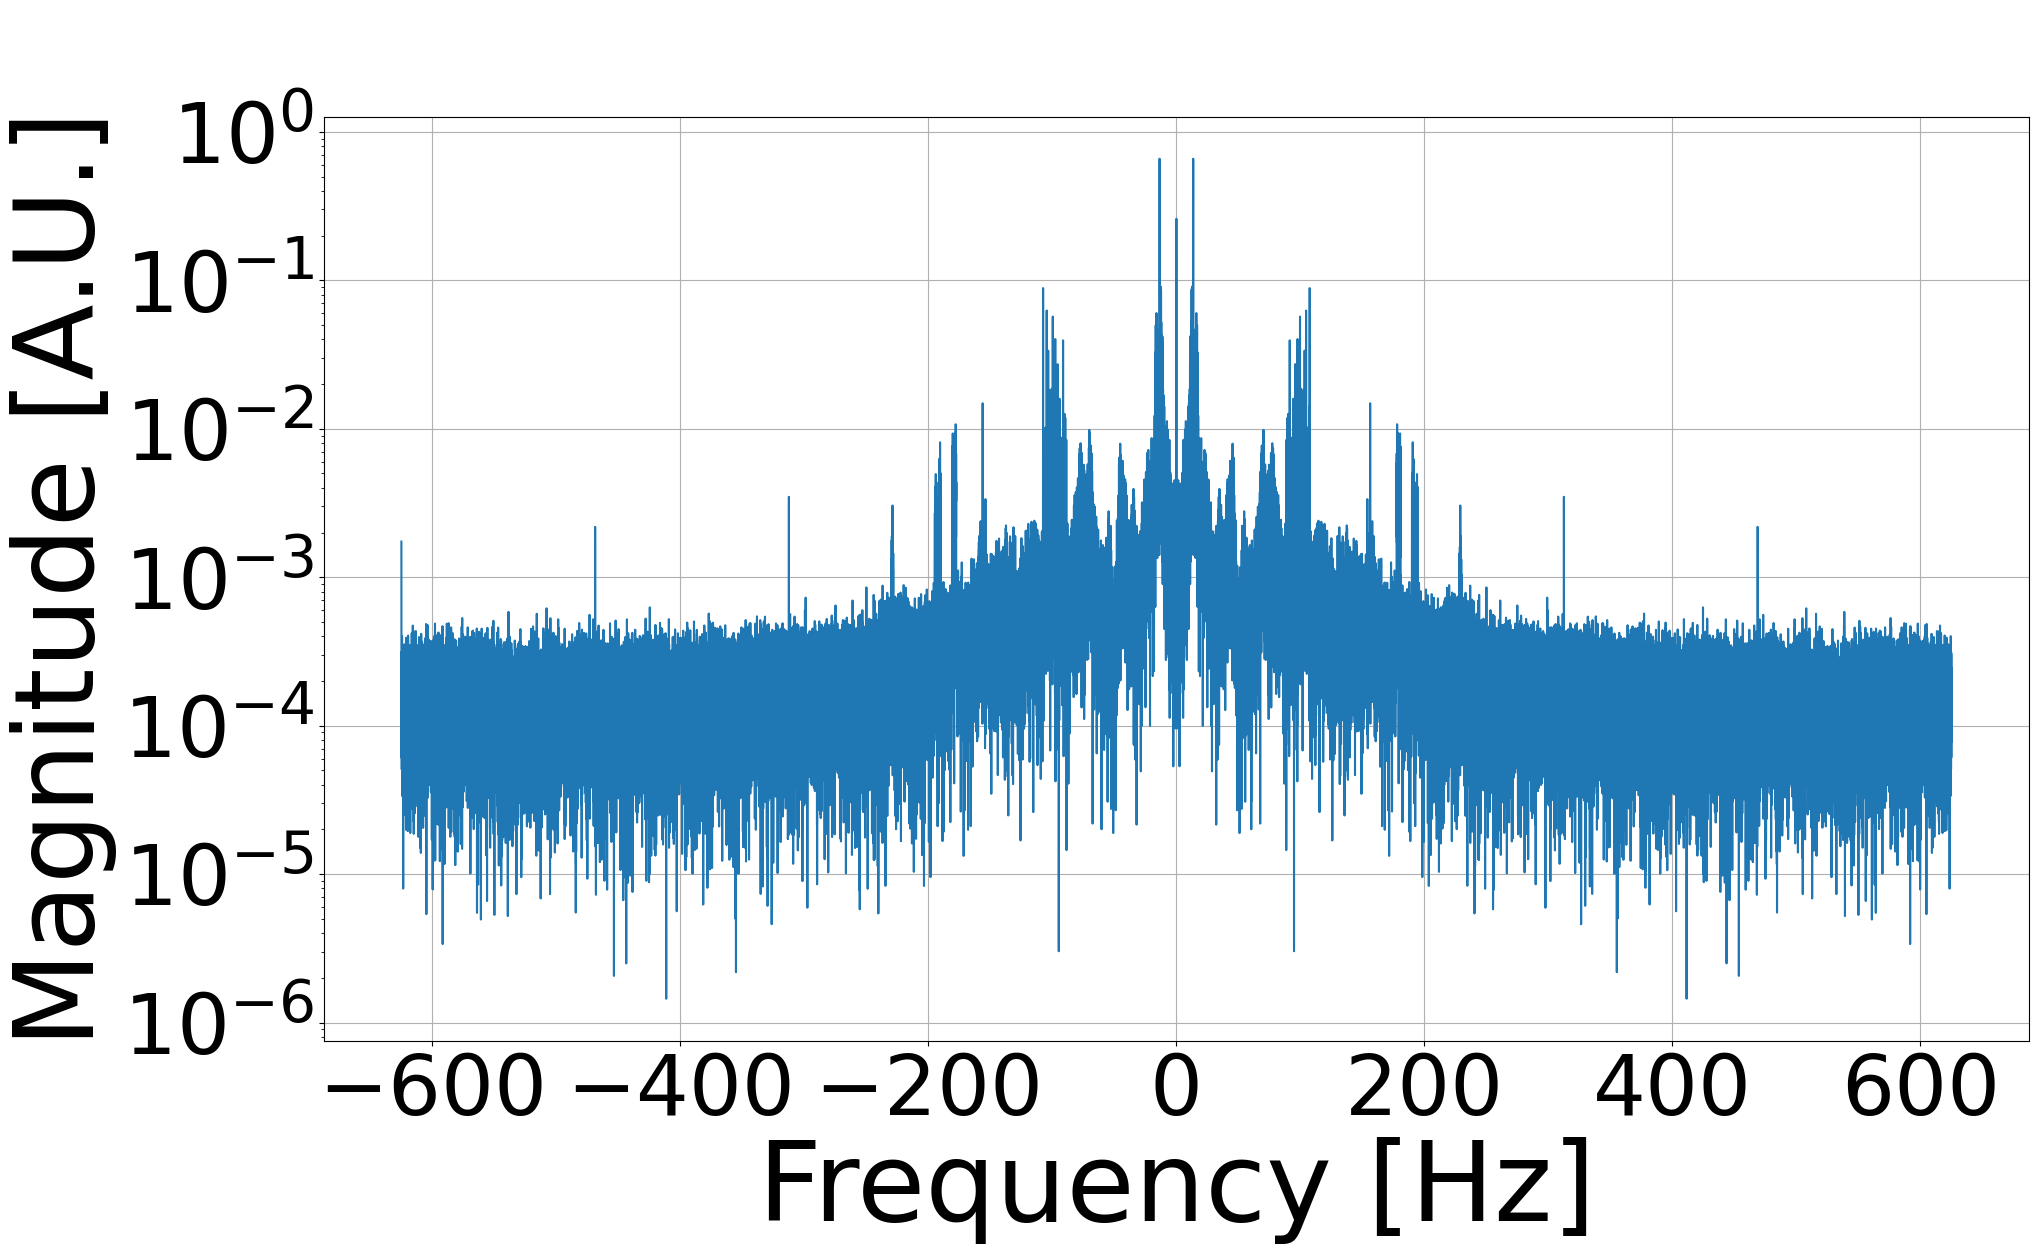

In [7]:
freqs_shifted = fft.fftshift(freqs)
reconstructed_fft_shifted = fft.fftshift(reconstructed_fft)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, np.abs(reconstructed_fft_shifted)/n)
plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

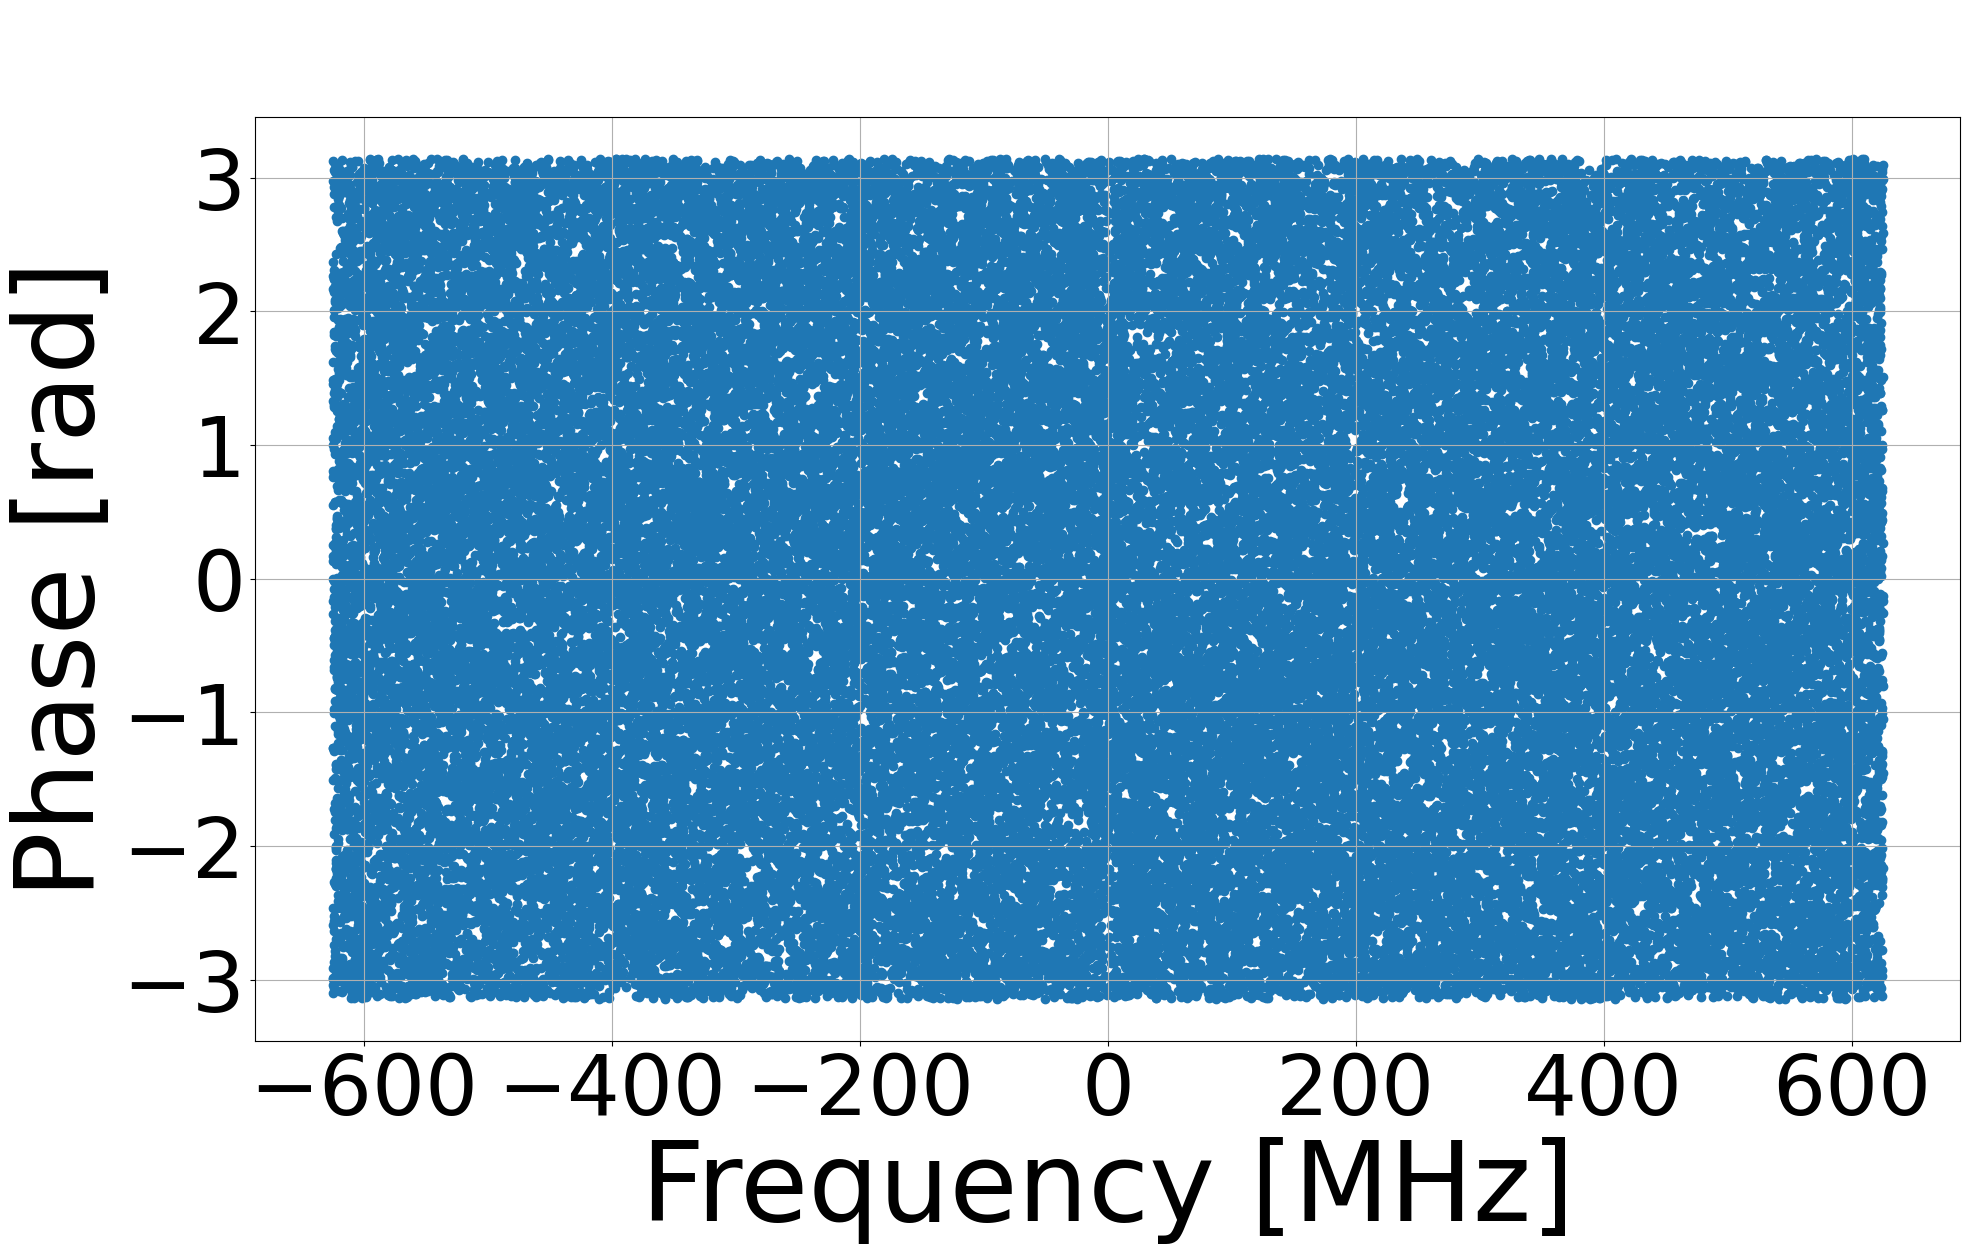

In [8]:
plt.figure(figsize=(22, 12))
plt.scatter(freqs, avg_phases)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [rad]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)

#plt.savefig("../Results/080824_15.42/wrong_phases_2.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [29]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_reconstructed_fft = reconstructed_fft[:round((N/2))]
    pos_avg_phases = avg_phases[:round((N/2))]
    pos_avg_phases_2 = avg_phases_2[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_reconstructed_fft = reconstructed_fft[:round((N-1)/2 + 1)]
    pos_avg_phases = avg_phases[:round((N-1)/2 + 1)]
    pos_avg_phases_2 = avg_phases_2[:round((N-1)/2 + 1)]

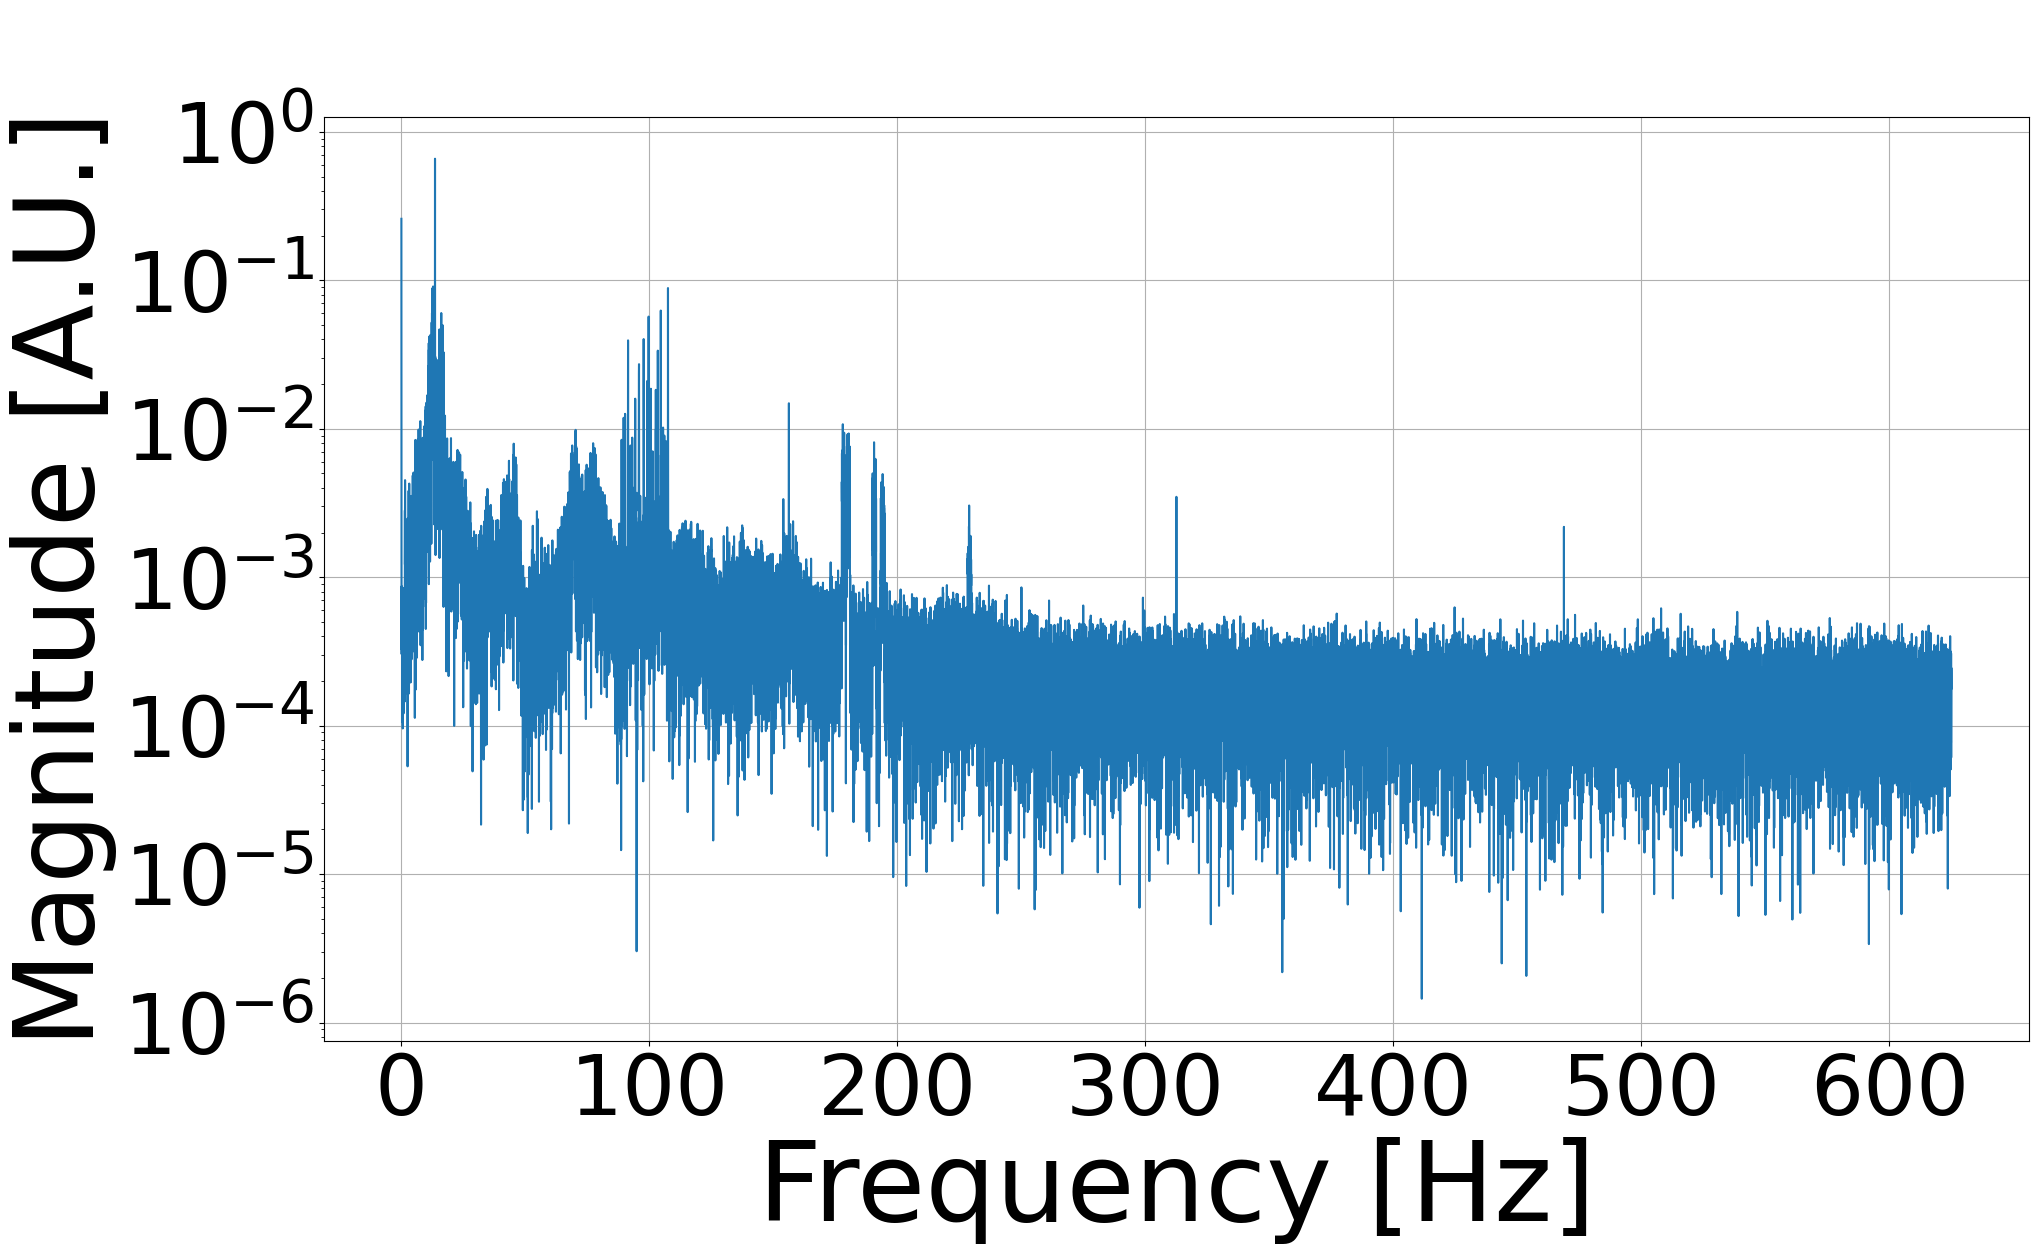

In [10]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, np.abs(pos_reconstructed_fft)/n)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

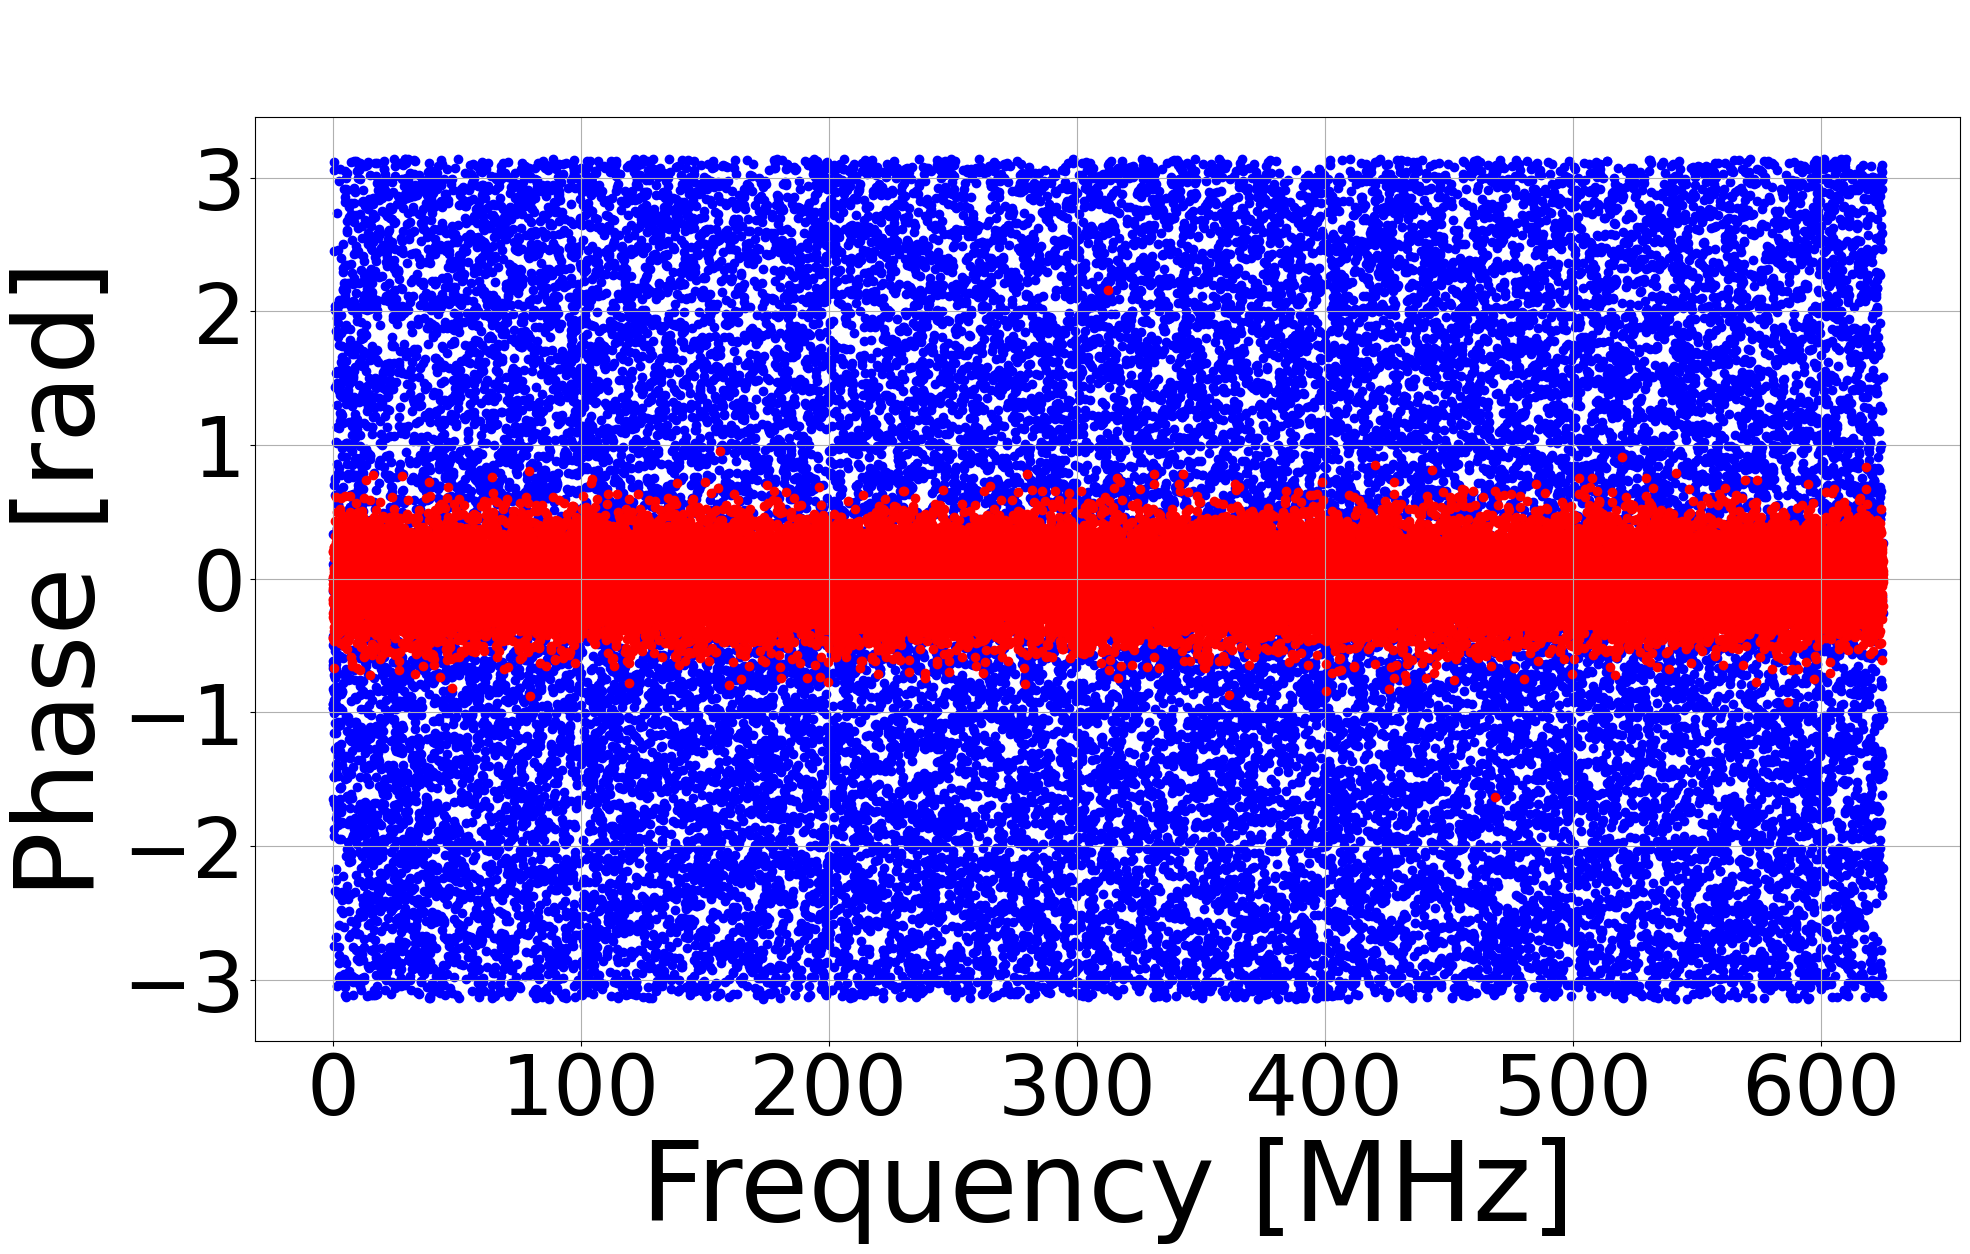

In [38]:
plt.figure(figsize=(22, 12))
plt.scatter(pos_freqs, pos_avg_phases, label = 'average of the phases', color = 'blue')
plt.scatter(pos_freqs, pos_avg_phases_2, label = 'phases of the average', color = 'red')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [rad]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)

#plt.savefig("../Results/080824_15.42/right_VS_wrong_phases.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/right_VS_wrong_phases.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [12]:
f1 = 13
f2 = 14

In [13]:
print(f"positive peak frequency: {pos_freqs[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_reconstructed_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]} Hz")
print(f"positive peak phase: {pos_avg_phases[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_reconstructed_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]*180/np.pi} deg")

positive peak frequency: 13.559348969554188 Hz
positive peak phase: 48.74301901458611 deg


## Filtering

In [14]:
noise_ffts, peak_f, peak_phases = filtering_func_4(freqs, all_magnitudes, avg_phases, f1, f2)
noise_wfs = fft.ifft(noise_ffts, axis = 1)
avg_noise_wf = np.mean(noise_wfs.real, axis = 0)

peak_f: [ 13.55934897 -13.55934897]
peak_phase: [ 0.85072617 -0.85072617]
sum: 2


In [15]:
A = max(avg_noise_wf)
f = peak_f[0]
phi = peak_phases[0]
coswave = A*np.cos(f*np.pi*2*times + phi)

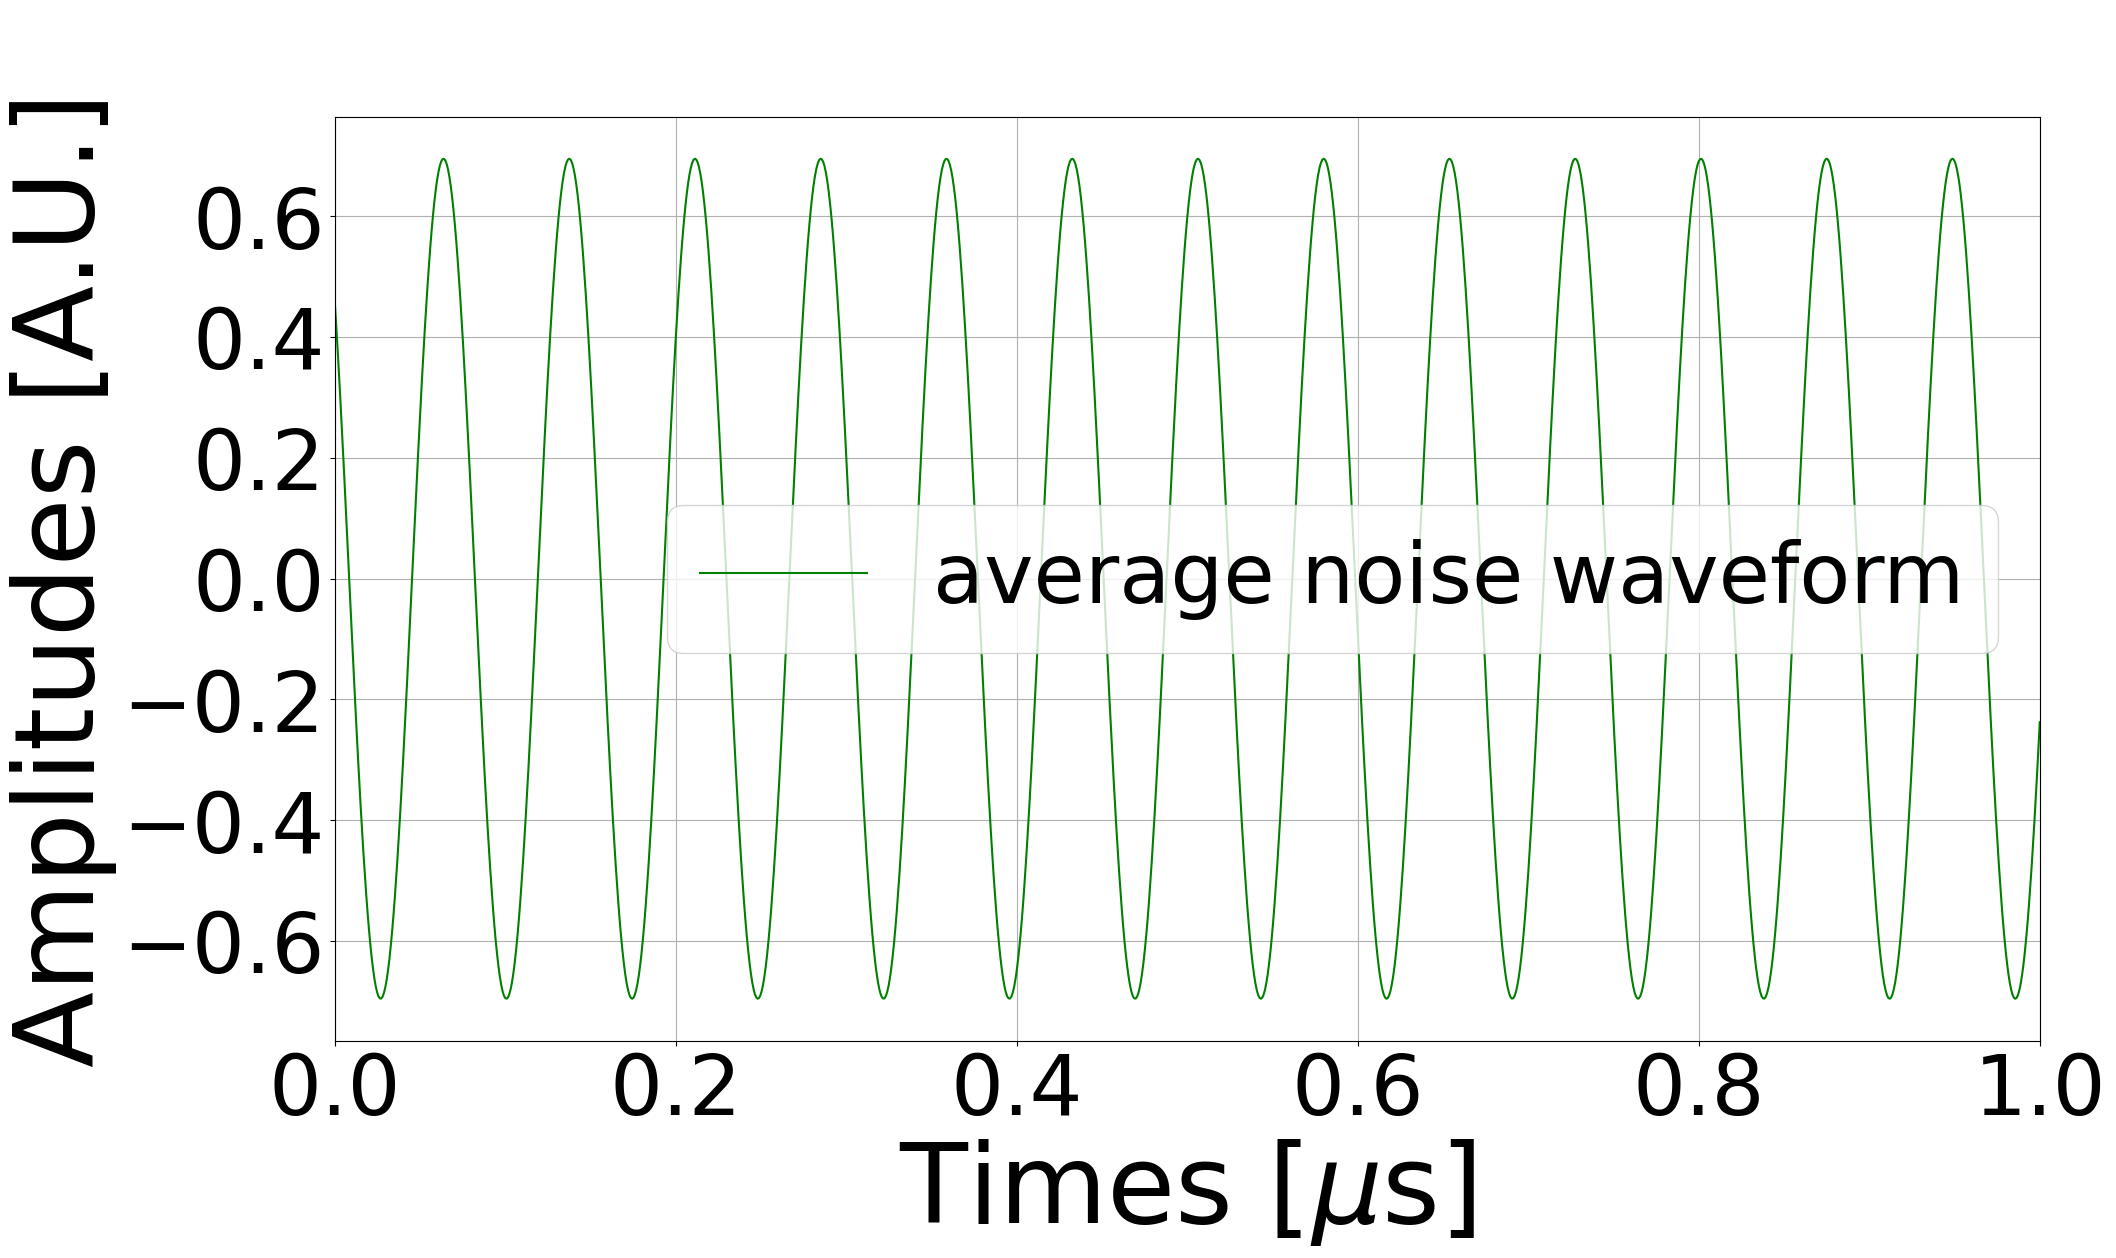

In [25]:
plt.figure(figsize=(22, 12))
plt.plot(times, avg_noise_wf.real, color = 'green', label = 'average noise waveform') #you can see that it remembers the phase only if you pass the complex numbers as fft to fft.ifft
plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'expected noise waveform')
plt.plot(times, avg_noise_wf.real - coswave, color = 'purple', label = 'difference')

plt.title(' ', fontsize = 80)
plt.xlabel(r'Times [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitudes [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("../Results/080824_15.42/method2_avg_noise_wf_test4.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_avg_noise_wf_test4.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [17]:
print(np.arccos((avg_noise_wf.real)[times == 0]/A)*180/np.pi)
print(np.arccos((coswave)[times == 0]/A)*180/np.pi)

[48.74301882]
[48.74301901]


## Compare to average waveform

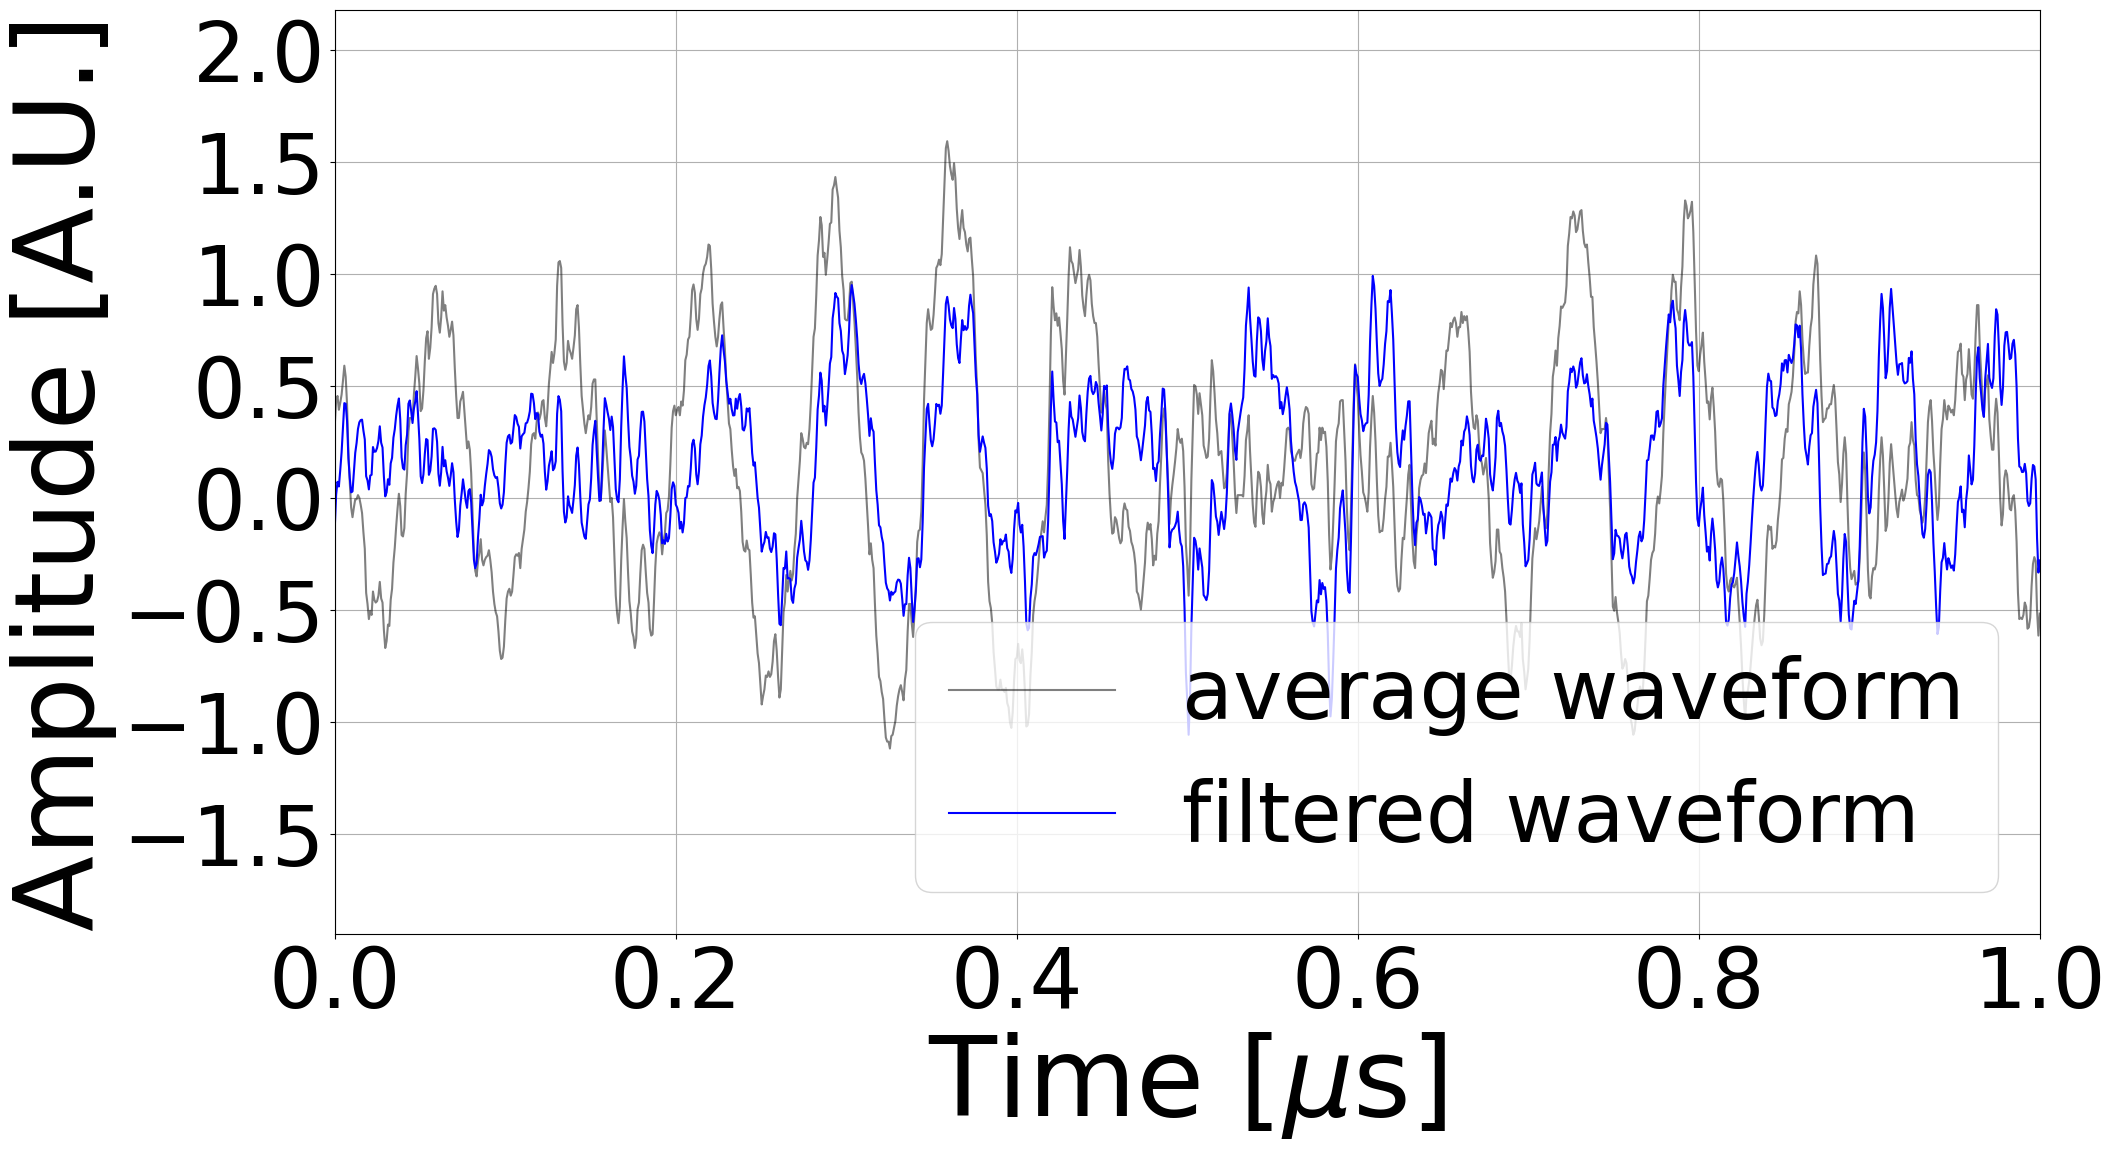

In [18]:
plt.figure(figsize = (22, 12))
plt.plot(times, avg_wf, label = 'average waveform', color = 'black', alpha = 0.5)
plt.plot(times, avg_wf - avg_noise_wf, label = 'filtered waveform', color = 'blue')

plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_filtered_wf_test4.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [19]:
avg_filtered_wf = avg_wf - avg_noise_wf

In [20]:
reconstructed_filtered_fft = fft.fft(avg_filtered_wf)

c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\transforms.py:992: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


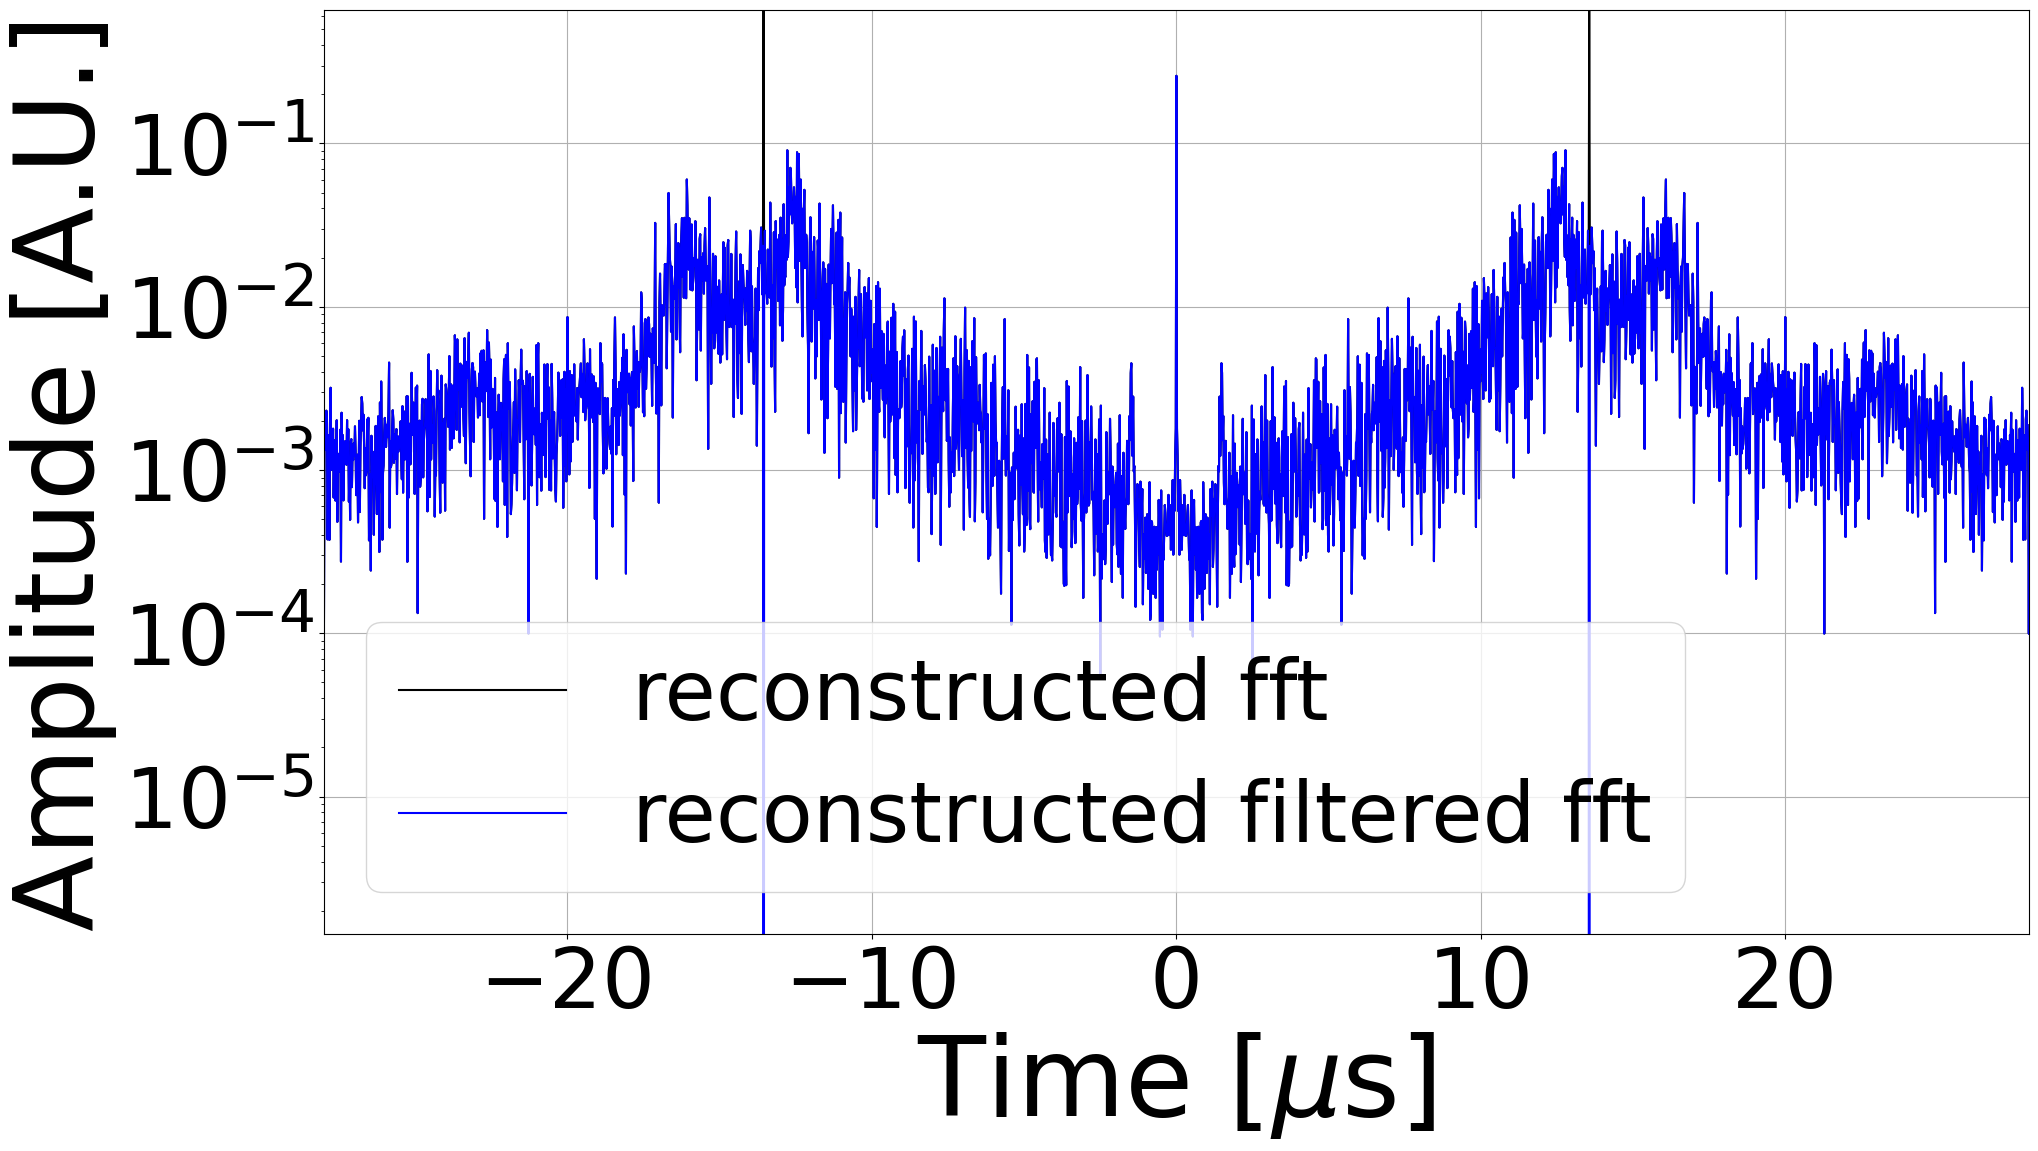

In [21]:
reconstructed_filtered_fft_shifted = fft.fftshift(reconstructed_filtered_fft)

plt.figure(figsize = (22, 12))
plt.plot(freqs_shifted, np.abs(reconstructed_fft_shifted)/n, color = 'k', label = 'reconstructed fft')
plt.plot(freqs_shifted, np.abs(reconstructed_filtered_fft_shifted)/n, label = 'reconstructed filtered fft', color = 'blue')

plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.semilogy()
plt.ylim([min(np.abs(reconstructed_fft_shifted)/n), max(np.abs(reconstructed_fft_shifted)/n)])  # Adjust the y-axis range
plt.xlim(-f2*2, f2*2)
plt.legend(loc = 'lower left', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [22]:
if (N%2 == 0):
    pos_avg_filtered_fft = reconstructed_filtered_fft[:round((N/2))]
else:
    pos_avg_filtered_fft = reconstructed_filtered_fft[:round((N-1)/2 + 1)]

c:\Users\giuly\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


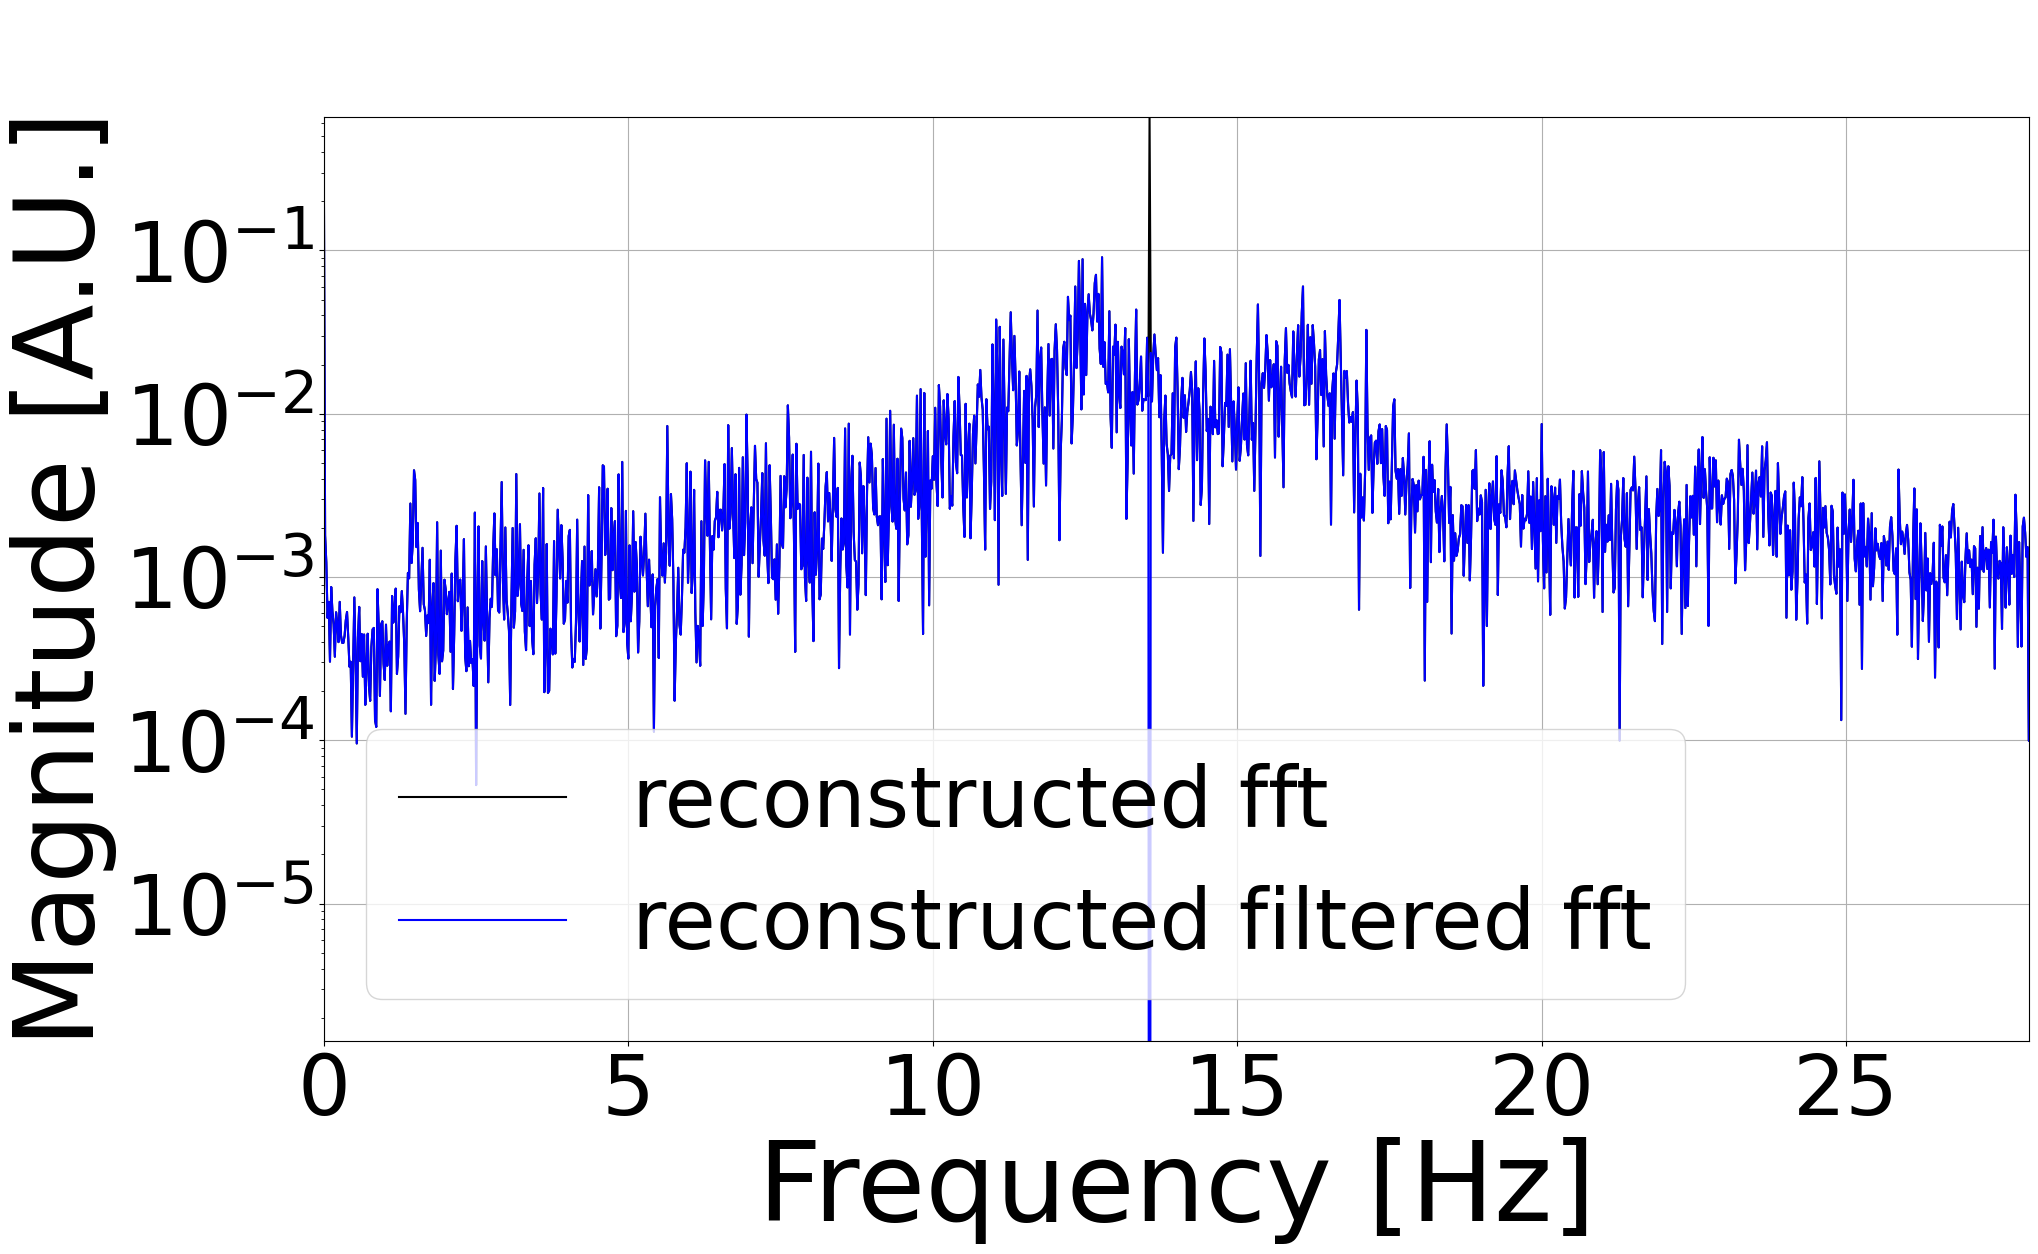

In [23]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, np.abs(pos_reconstructed_fft)/n, color = 'k', label = 'reconstructed fft')
plt.plot(pos_freqs, np.abs(pos_avg_filtered_fft)/n, color = 'blue', label = 'reconstructed filtered fft')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, f2*2)
plt.ylim([min(np.abs(pos_reconstructed_fft)/n), max(np.abs(pos_reconstructed_fft)/n)])  # Adjust the y-axis range
plt.legend(loc = 'lower left', fontsize = 60)
plt.semilogy()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()